In [1]:
import sounddevice as sd
import matplotlib.pyplot as plt

from synthoor import GatedSound, Envelope, Oscillator, LatencyGate, ButterFilter
%load_ext autoreload
%autoreload 2

### Oscillator

In [2]:
osc0 = Oscillator('sine')
osc_play = osc0(freq = 200)
sd.play(osc_play)

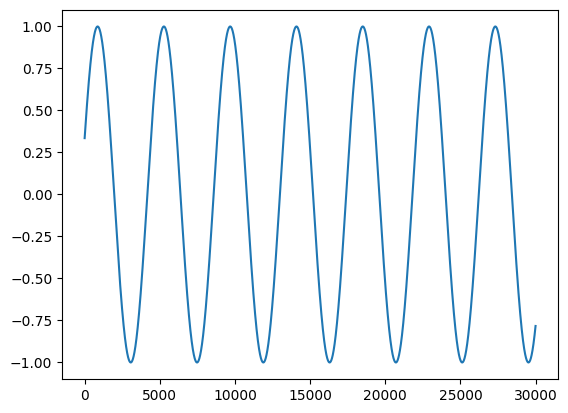

In [3]:
plt.plot(osc0(freq = 10))

### Frequency Modulation

In [4]:
modulate_osc = osc0(freq=5)
osc1 = Oscillator('sine')
modulated_osc = osc1(modulate_osc, freq=300)
sd.play(modulated_osc)

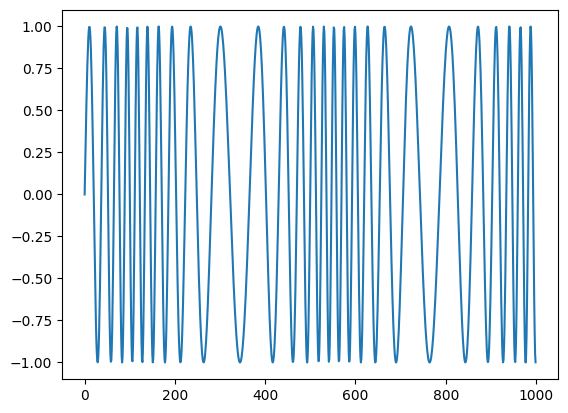

In [5]:
osc0 = Oscillator('sine', 100)
osc1 = Oscillator('sine', 1000)
a0 = osc0() * 12
a1 = osc1(a0)
plt.plot(a1[:1000])

### ASDR Envelope

In [6]:
frames = 50000
gate = LatencyGate()
osc_sine = osc0(
    freq = 300,
    frames=frames
)
asdr = Envelope(
    attack=0.4, 
    decay=0.1,
    sustain=0.5,
    release=0.5
)
gate.open(dt=0.1)
gate.close(dt=0.5)
g0 = gate(frames=frames)
enveloped_wave = osc_sine * asdr(g0)
sd.play(enveloped_wave)

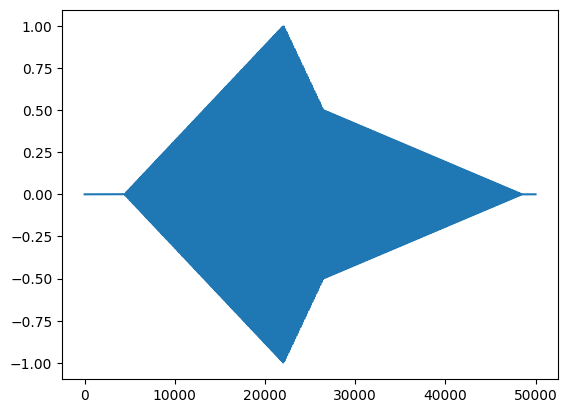

In [7]:
plt.plot(enveloped_wave)

### Butter Filter
The Butterworth filter is a type of signal processing filter designed to have a frequency response that is as flat as possible in the passband. It is also referred to as a maximally flat magnitude filter. It is based on the notion that 

> **An ideal electrical filter should not only completely reject the unwanted frequencies but should also have uniform sensitivity for the wanted frequencies**

In [8]:
osc_sine = osc0(
    freq = 600,
)
bfilter = ButterFilter(
    freq=200,
    btype='lowpass'
)
filtered_wave = bfilter(osc_sine)
sd.play(filtered_wave)

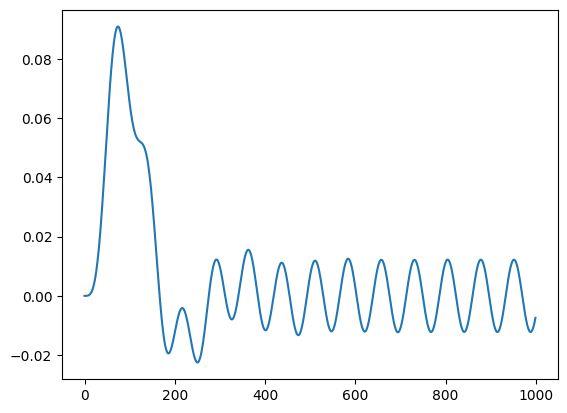

In [9]:
plt.plot(filtered_wave[:1000])

### Programming Synthesizers

In [11]:
class SimpleSynth(GatedSound):

    def __init__(self):

        super().__init__()

        self.osc0 = Oscillator('sine')

    def forward(self):
        
        g0 = self.gate()
        a0 = self.osc0()

        return a0 * g0

s = SimpleSynth()
s.play(
    duration=0.5
)

### TB303: Acid Synth

In [12]:
class TB303(GatedSound):

    def __init__(self):

        super().__init__()

        self.env0 = Envelope(0.05, 0., 1., 0.01)
        self.env1 = Envelope(0., 1., 0., 0., linear=False)

        self.osc0 = Oscillator('saw')

        self.filter = ButterFilter(btype='lowpass')

    def forward(self):

        g0 = self.gate()

        e0 = self.env0(g0)
        e1 = self.env1(g0, decay=1) * 12 * 10

        a0 = self.osc0(freq=self.freq)

        a1 = self.filter(
            a0,
            key_modulation=e1,
            freq=self.freq,
        )

        return a1 * e0
    
t = TB303()
t.play(
    note=60,
)

## Wobbler (Experimental synth that wobbles)

In [ ]:
import math
import numpy as np
from synthoor.config import FPS

class Wobbler(GatedSound):
    def __init__(self):
        super().__init__()
        # Oscillator
        self.osc = Oscillator("square")

        # Filter - Low-pass with some resonance (adjust db for resonance)
        self.filter = ButterFilter(btype="lowpass", freq=1000, db=12) # Lower freq, some resonance
        self.filter_cutoff_env_amount = 12 * 6  # Modulation depth in semitones
        self.wobble_rate = 5  # Hz - Speed of the wobble
        self.wobble_depth = 12 * 2 # Semitones - Amount of wobble

        # Amplitude Envelope (ADSR) - Medium attack/release
        self.amp_env = Envelope(attack=0.1, decay=0.3, sustain=0.6, release=0.7)
        # Filter Envelope (ADSR) - Faster attack, controls filter sweep
        self.filter_env = Envelope(attack=0.05, decay=0.5, sustain=0.2, release=1.0)

        # Internal state for wobble LFO phase
        self._wobble_phase = 0.0

    def forward(self):
        # Gate signal
        gate_signal = self.gate()

        # Amplitude Envelope
        amp_mod = self.amp_env(gate_signal)

        # Filter Envelope modulation amount
        filter_env_mod = self.filter_env(gate_signal) * self.filter_cutoff_env_amount

        # Generate time vector for the frame buffer
        t = (self.index + np.arange(self.frames)) / FPS
        # Calculate wobble modulation using sine wave based on time
        wobble_lfo = np.sin(2 * math.pi * self.wobble_rate * t + self._wobble_phase) * self.wobble_depth
        # Update phase for next buffer - not perfect but gives continuous feel
        self._wobble_phase = (2 * math.pi * self.wobble_rate * (self.index + self.frames) / FPS) % (2 * math.pi)


        # Combine filter envelope and wobble LFO for filter modulation
        # Let's average the LFO over the frame
        avg_wobble_lfo = np.mean(wobble_lfo) # Simpler approach
        total_filter_mod = filter_env_mod + avg_wobble_lfo # Add wobble to envelope mod

        # Oscillator output
        osc_output = self.osc(freq=self.freq)

        # Apply filter with combined envelope and LFO modulation
        filtered_sound = self.filter(osc_output, key_modulation=total_filter_mod)

        output_signal = filtered_sound * amp_mod

        return output_signal

    def reset(self, shared=False):
        super().reset(shared)
        self._wobble_phase = 0.0

t = Wobbler()
t.play(
    note=40,
    duration=0.4
)

## Listen to MIDI

In [ ]:
import mido
print(mido.get_input_names())

['IAC Driver Bus 1', 'IAC Driver Bus 2', 'Minilab3 MIDI', 'Minilab3 DIN THRU', 'Minilab3 MCU/HUI', 'Minilab3 ALV']


In [23]:
import mido
import time

# MIDI listening logic
def listen_to_midi(port_name):
    try:
        with mido.open_input(port_name) as inport:
            print(f"Listening for MIDI messages on {port_name}...")
            for msg in inport:
                print(msg) # Print the received message
                if msg.type == 'note_on' and msg.velocity > 0:
                    s = Wobbler()
                    print(f"Playing note: {msg.note}, velocity: {msg.velocity}")
                    s.play(note=msg.note, velocity=msg.velocity, duration=0.5) # Fixed 0.5 second duration

    except OSError as e:
        print(f"Error opening MIDI port '{port_name}': {e}")
        print("Please ensure the MIDI device is connected and the port name is correct.")
        print("Available ports:", mido.get_input_names())
    except KeyboardInterrupt:
        print("\nStopping MIDI listener.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

available_ports = mido.get_input_names()
target_port = "Minilab3 MIDI"
listen_to_midi(target_port)

Listening for MIDI messages on Minilab3 MIDI...
note_on channel=0 note=36 velocity=123 time=0
Playing note: 36, velocity: 123
note_off channel=0 note=36 velocity=0 time=0
note_on channel=0 note=43 velocity=127 time=0
Playing note: 43, velocity: 127
note_off channel=0 note=43 velocity=0 time=0
note_on channel=0 note=36 velocity=1 time=0
Playing note: 36, velocity: 1
note_off channel=0 note=36 velocity=0 time=0
note_on channel=0 note=48 velocity=127 time=0
Playing note: 48, velocity: 127
note_off channel=0 note=48 velocity=0 time=0
note_on channel=0 note=40 velocity=112 time=0
Playing note: 40, velocity: 112
note_off channel=0 note=40 velocity=0 time=0
note_on channel=0 note=41 velocity=127 time=0
Playing note: 41, velocity: 127
note_off channel=0 note=41 velocity=0 time=0
note_on channel=0 note=43 velocity=127 time=0
Playing note: 43, velocity: 127
note_off channel=0 note=43 velocity=0 time=0
note_on channel=0 note=45 velocity=119 time=0
Playing note: 45, velocity: 119
note_off channel=